<a href="https://colab.research.google.com/github/developerabhi14/ML-Notebooks/blob/main/Sign_Language_Detection_with_Resnet18_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# --- Config ---
BATCH_SIZE = 64
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# --- Custom Dataset Class ---
class SignLanguageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = int(self.data.iloc[idx, 0])
        image = self.data.iloc[idx, 1:].values.reshape(28, 28).astype(np.uint8)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
df = pd.read_csv("sign_mnist_train.csv")
df_test = pd.read_csv("sign_mnist_test.csv")

In [5]:
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Required for ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [7]:
train_dataset = SignLanguageDataset(train_df, transform)
val_dataset = SignLanguageDataset(val_df, transform)
test_dataset = SignLanguageDataset(df_test, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [8]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 25)  # 25 classes for A-Y (excluding J)
model = model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.8MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [10]:
losses=[]
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss/len(train_loader))
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/5], Loss: 0.0784
Epoch [2/5], Loss: 0.0129
Epoch [3/5], Loss: 0.0003
Epoch [4/5], Loss: 0.0002
Epoch [5/5], Loss: 0.0001


In [11]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       1.00      1.00      1.00       144
   

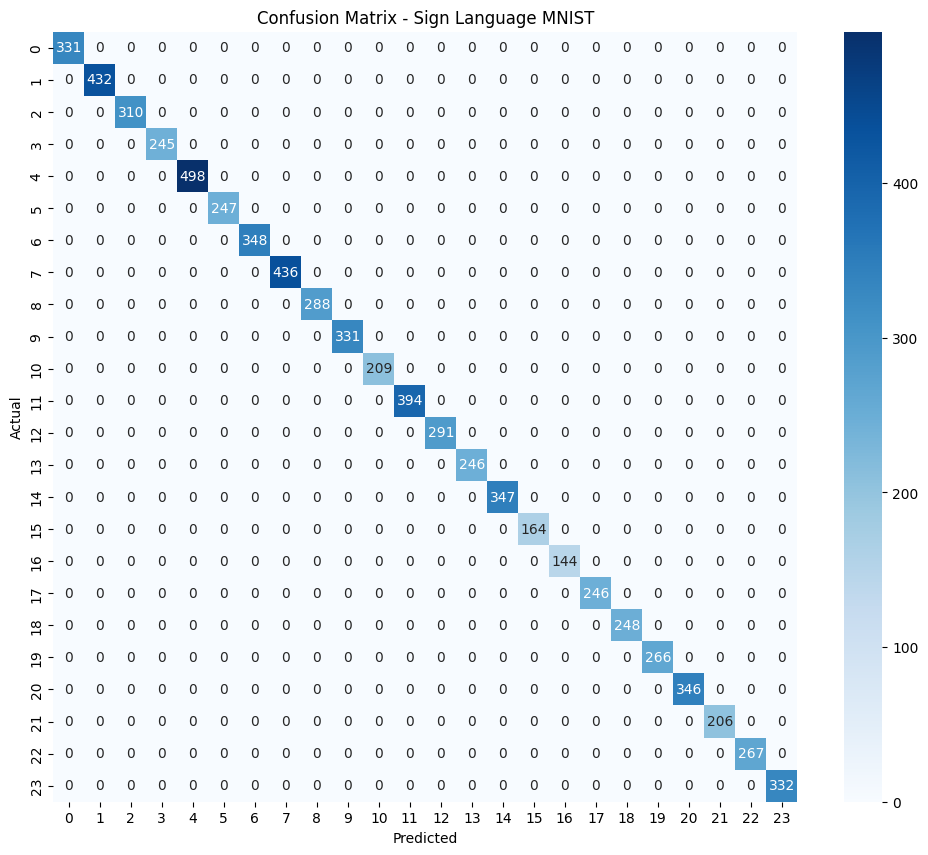

In [12]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Sign Language MNIST")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()